In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import datasets
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data() # keras帶有mnist 等 7種dataset
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [3]:
#特徵縮放(0,1)
# x_train = train_images.astype(np.float32)/255.0
# x_test = test_images.astype(np.float32)/255.0


x_train = train_images.astype(np.float32)
x_test = test_images.astype(np.float32)
x_train[1]
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

#labels
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
y_train[0], train_labels[0]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 array([6], dtype=uint8))

In [4]:
weight_decay = 1e-4
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(filters=60,
                           kernel_size=(3,3),
                           strides=(1,1),
                           padding='same',
                           activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay),
                           input_shape=(32,32,3)
                           ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=60,
                           kernel_size=(3,3),
                           strides=(1,1),
                           padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay),
                           activation='relu',
                           ),
    tf.keras.layers.MaxPooling2D((2,2)), #池化層 減少參數
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(filters=80,
                           kernel_size=(3,3),
                           strides=(1,1),
                           padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay),
                           activation='relu',
                           ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=80,
                           kernel_size=(3,3),
                           strides=(1,1),
                           padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay),
                           activation='relu',
                           ),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(filters=100,
                           kernel_size=(3,3),
                           strides=(1,1),
                           padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay),
                           activation='relu',
                           ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=100,
                           kernel_size=(3,3),
                           strides=(1,1),
                           padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay),
                           activation='relu',
                           ),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
 
    tf.keras.layers.Flatten(),   
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 60)        1680      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 60)        240       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 60)        32460     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 60)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 60)        240       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 80)        43280     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 80)        3

In [5]:
#ImageDataGenerator 圖片產生器
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rotation_range=30, #旋轉
                    width_shift_range = 0.1, #左右平移
                    height_shift_range = 0.1, #上下平移
                    horizontal_flip = True,
                    featurewise_center=True,
                    featurewise_std_normalization=True)  #水平翻轉

#featurewise_center=True,
#featurewise_std_normalization=True

In [6]:
#編譯模型
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [10]:
#訓練模型
history = model.fit(train_datagen.flow(x_train, y_train),
                   batch_size=64,
                   epochs=50, #還沒試50
                   validation_data=(x_test, y_test),
                   verbose=1)

Epoch 1/50
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2788 - accuracy: 0.5429 - val_loss: 1.0122 - val_accuracy: 0.6534
Epoch 2/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.9812 - accuracy: 0.6577 - val_loss: 1.0163 - val_accuracy: 0.6715
Epoch 3/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.8485 - accuracy: 0.7074 - val_loss: 0.7057 - val_accuracy: 0.7589
Epoch 4/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.7494 - accuracy: 0.7412 - val_loss: 0.6570 - val_accuracy: 0.7804
Epoch 5/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.6798 - accuracy: 0.7675 - val_loss: 0.6177 - val_accuracy: 0.7944
Epoch 6/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.6361 - accuracy: 0.7811 - val_loss: 0.7045 - val_accuracy: 0.7732
Epoch 7/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.5895 - accuracy: 0.7970 - val_loss: 0.5817 -

Text(0, 0.5, 'accuracy')

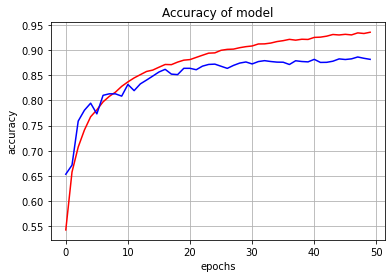

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Accuracy of model')
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

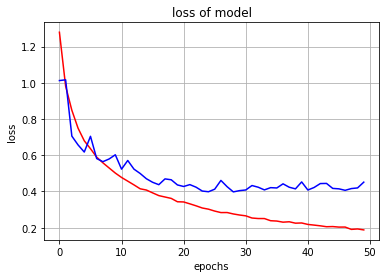

In [12]:
plt.title('loss of model')
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')

In [14]:
#預測
y_pred = model.predict(x_test)
y_pred[0]
y_hat = np.argmax(y_pred, axis=1)
y_hat

#crosstab 混淆矩陣/交叉列表
import pandas as pd
pd.crosstab(test_labels.flatten(), y_hat, rownames=['label'], colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,903,18,5,14,11,1,4,2,17,25
1,2,973,0,0,0,0,0,0,2,23
2,38,5,806,45,53,13,23,11,5,1
3,14,5,29,771,46,53,52,13,4,13
4,4,2,14,16,918,8,23,9,1,5
5,3,1,25,106,30,777,23,26,2,7
6,5,4,18,14,9,1,946,0,0,3
7,4,1,13,25,36,13,4,893,2,9
8,38,29,3,6,1,0,3,1,891,28


In [15]:
model.save('CIFAR_CNN_model_batchNormalization.h5')